# Experiments with Multi Scale Entropy for Unsupervised Classification

Reference: https://arxiv.org/abs/2206.13529

## Imports

In [4]:
import pickle
import umap

import matplotlib.pyplot as plt
import numpy as np

from umap import UMAP
from pyentrp import entropy as ent
from scipy.interpolate import RegularGridInterpolator

## Load ELAsTiCC data set

In [2]:
def load(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)

In [3]:
test_dir = "/Users/vedshah/Documents/Research/UIUCSN/Projects/ELAsTiCC-Classification/processed/train"
X_ts = load(f"{test_dir}/x_ts.pkl")
X_static = load(f"{test_dir}/x_static.pkl")
Y = load(f"{test_dir}/y.pkl")
astrophysical_classes = load(f"{test_dir}/a_labels.pkl")

## Loop through and compute the entropies

In [57]:
cm = plt.get_cmap('gist_rainbow')
NUM_COLORS = 19
color_arr=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

In [63]:
mag_bin_width = 0.5


def get_shannon_entropy(mag, time, tau):

    N = len(mag)

    # Define edges of the time bins based on the time scale chosen (tau)
    time_bin_edges = np.arange(0, max(time) + tau, tau)

    # Define edges of the mag bins. This is somewhat arbitrary
    mag_bin_edges = np.arange(10, 30, mag_bin_width)

    # Compute 2D histogram of count
    hist, _, _ = np.histogram2d(time, mag, bins=[time_bin_edges, mag_bin_edges])

    # Sum along the time axis to find the number of observations points in each magnitude bin
    counts = np.sum(hist, axis=0)

    # Compute probability of being in each bin
    p = counts/N
    p = p[p>0]

    # Compute the Shanon entropy
    shannon_entropy = np.sum(-1 * p * np.log10(p))
    
    return shannon_entropy

def get_shannon_multiscale_entropy(mag, time, timescales):

    shannon_multiscale_entropy = []

    # Compute shannon entropy for each time scale
    for tau in timescales:

        shannon_entropy = get_shannon_entropy(mag, time, tau)
        shannon_multiscale_entropy.append(shannon_entropy)

    return shannon_multiscale_entropy

In [64]:
filtered_classes = []
filtered_entropies = []

for i in range(len(astrophysical_classes)):

    # Find the detections
    phot_flag = X_ts[i]['detection_flag']
    idx = np.where(phot_flag==1)[0]

    # Find the time series and rescale
    time = X_ts[i]['scaled_time_since_first_obs'].to_numpy()[idx] * 100
    flux = X_ts[i]['scaled_FLUXCAL'].to_numpy()[idx] * 1000

    # Time scale in days
    timescales = [0.5, 1, 2, 3, 5, 7, 10, 15, 20, 30, 40, 50, 60, 75, 90, 100]


    if len(idx) > 50 and np.all(flux > 0):

        # Convert from flux to mags
        mag = 27.5 - 2.5 * np.log10(flux)

        multiscale_entropies = get_shannon_multiscale_entropy(mag, time, timescales)
    
        filtered_classes.append(astrophysical_classes[i])
        filtered_entropies.append(multiscale_entropies)

In [65]:
filtered_entropies = np.array(filtered_entropies)
filtered_classes = np.array(filtered_classes)

In [66]:
reducer = UMAP()
embedding = reducer.fit_transform(filtered_entropies)
embedding.shape

/Users/vedshah/anaconda3/envs/multi-scale-entropy/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(46770, 2)

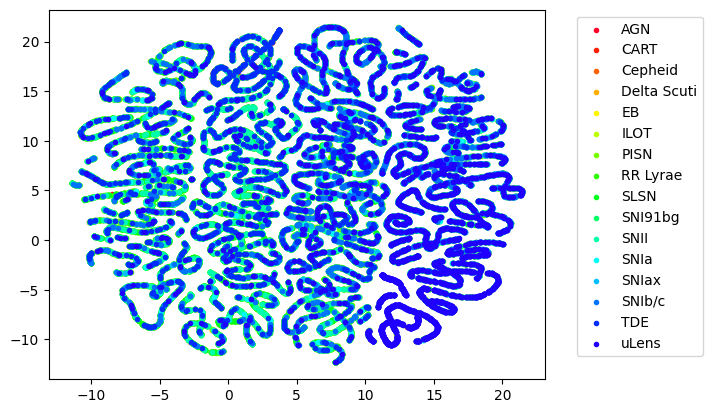

In [67]:
for i, c in enumerate(np.unique(filtered_classes)):
    idx = np.where(filtered_classes == c)[0]
    plt.scatter(embedding[idx, 0], embedding[idx, 1], label=c, marker='.', color=color_arr[i])
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


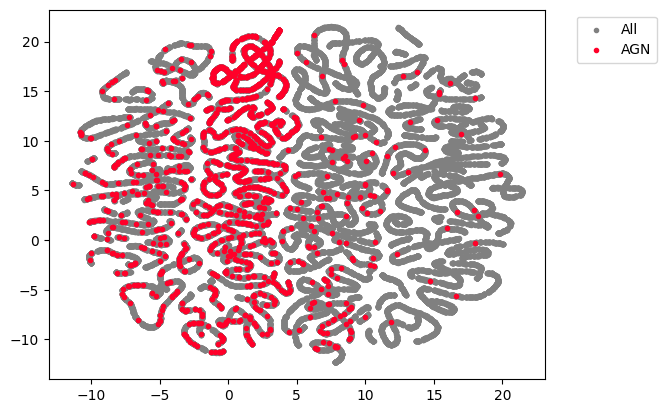

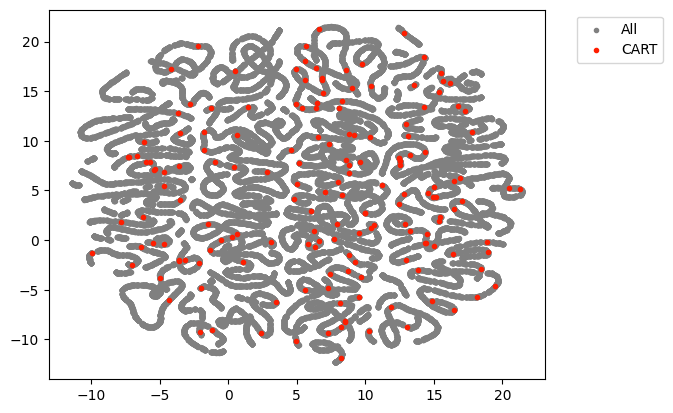

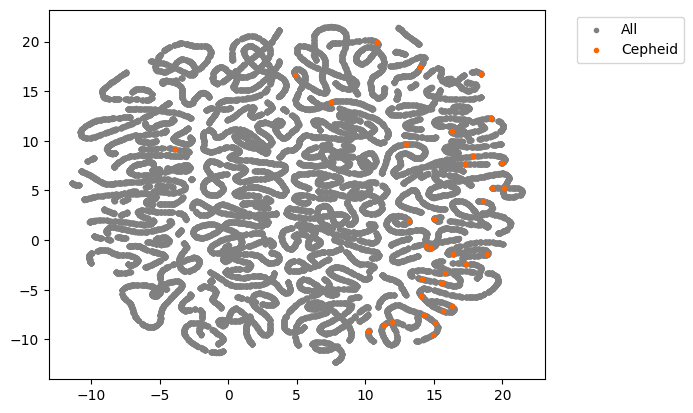

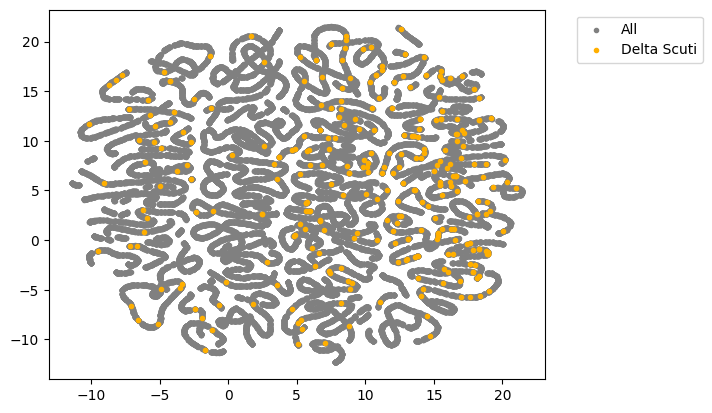

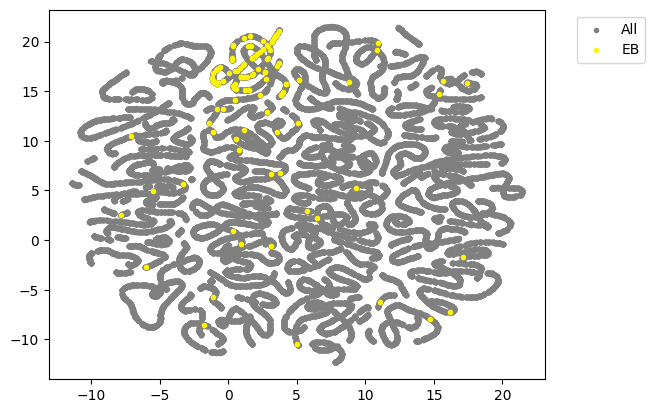

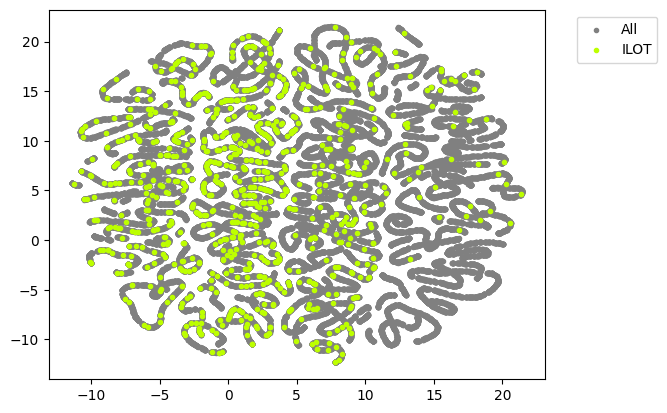

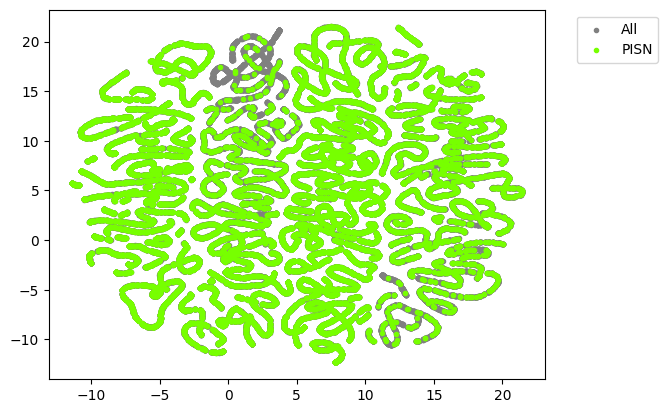

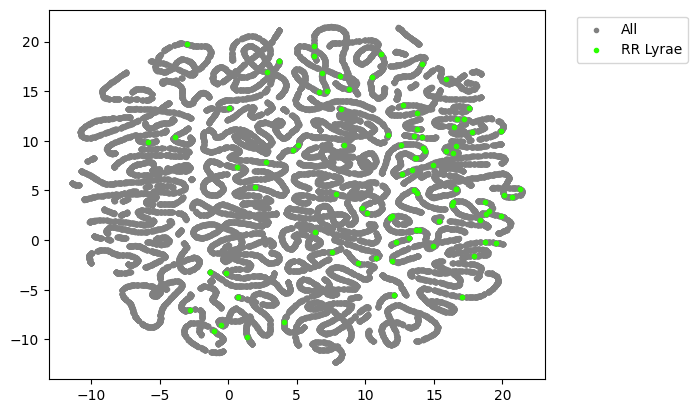

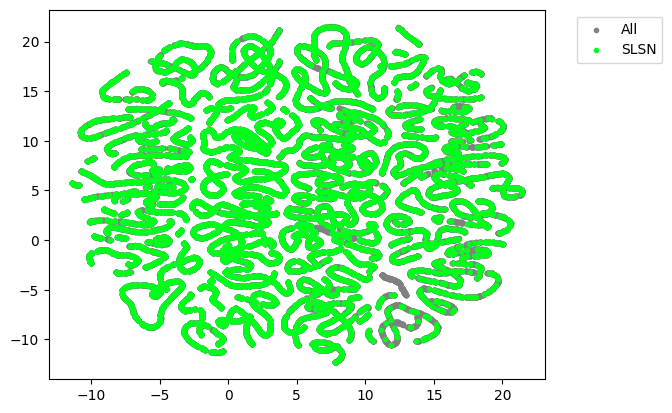

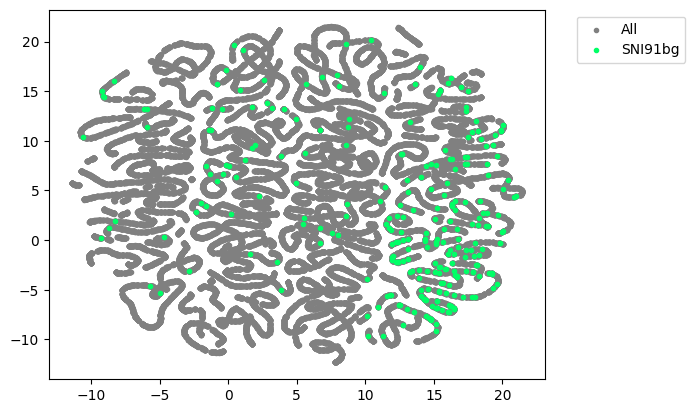

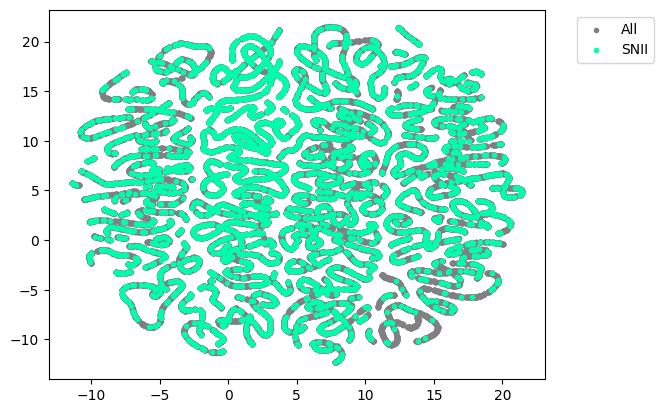

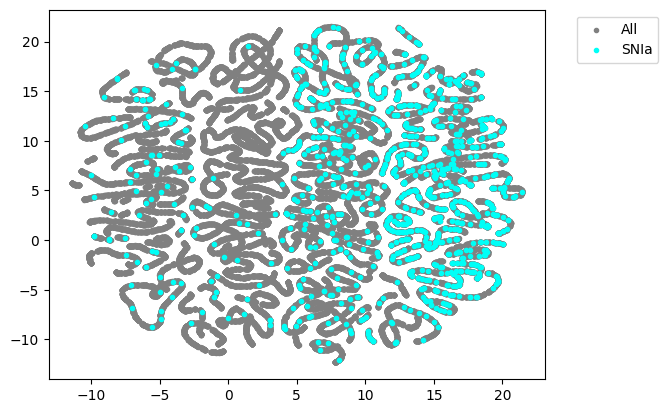

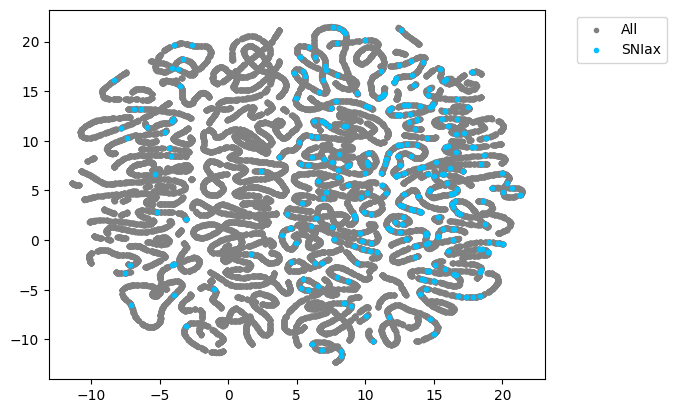

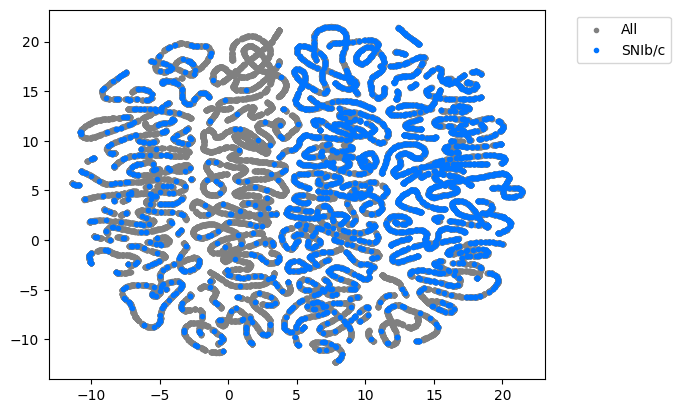

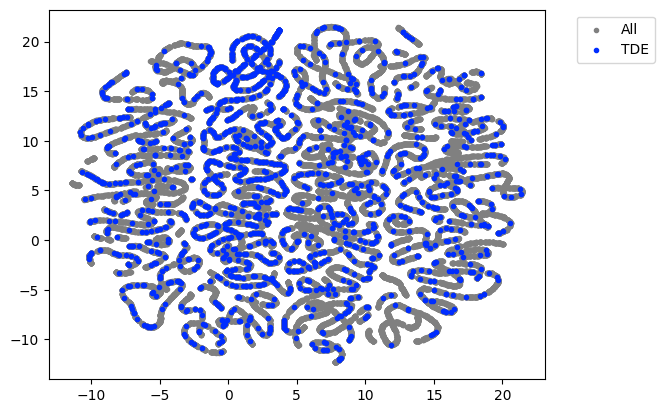

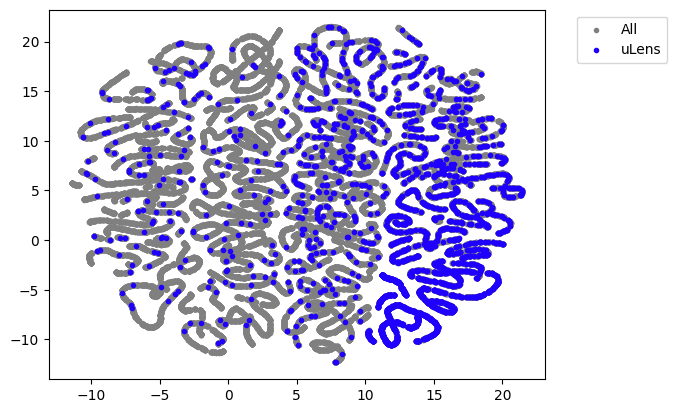

In [68]:

for i, c in enumerate(np.unique(filtered_classes)):
    idx = np.where(filtered_classes == c)[0]
    plt.scatter(embedding[:, 0], embedding[:, 1], label="All", marker='.', color='gray')
    plt.scatter(embedding[idx, 0], embedding[idx, 1], label=c, marker='.', color=color_arr[i])
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

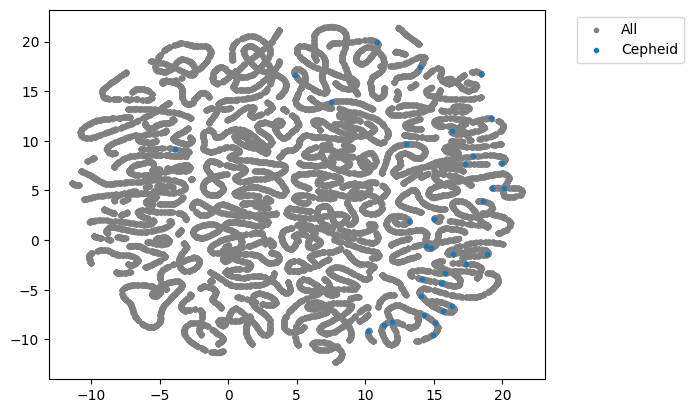

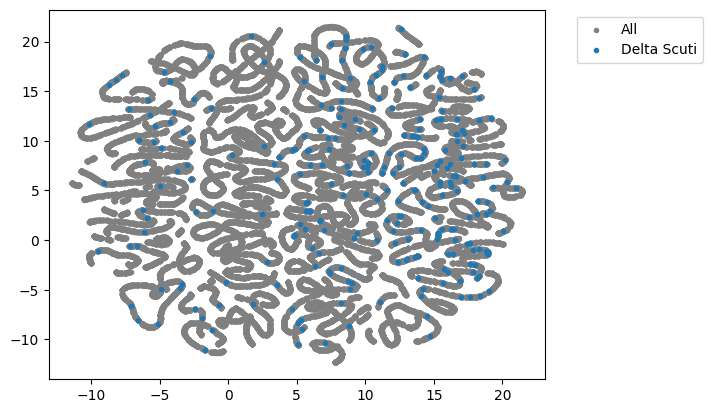

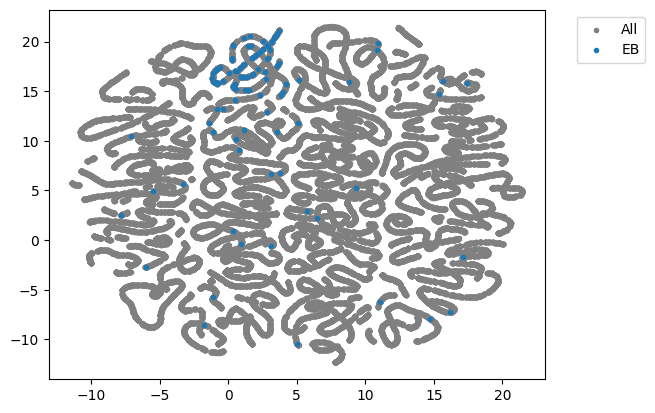

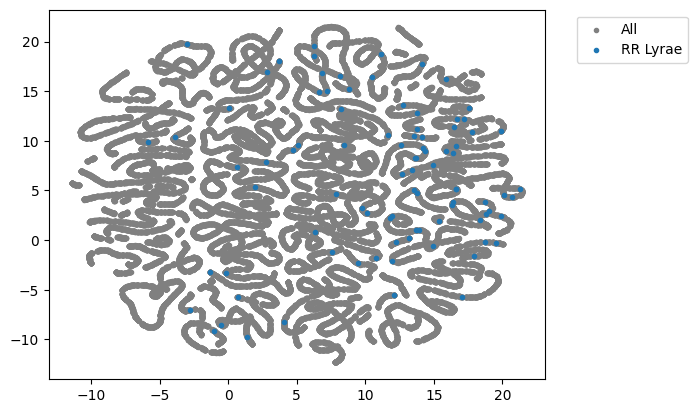

In [69]:
for c in np.unique(filtered_classes):
    idx = np.where(filtered_classes == c)[0]
    if c in ["Cepheid", "Delta Scuti", "EB", "RR Lyrae"]:
        plt.scatter(embedding[:, 0], embedding[:, 1], label="All", marker='.', color='gray')
        plt.scatter(embedding[idx, 0], embedding[idx, 1], label=c, marker='.')

        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()

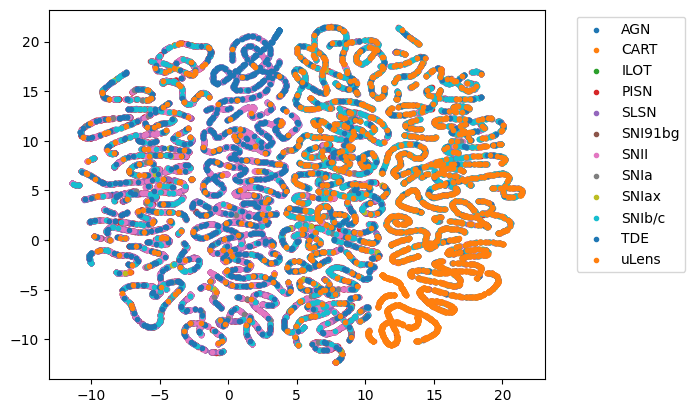

In [70]:
for c in np.unique(filtered_classes):
    idx = np.where(filtered_classes == c)[0]
    if c not in ["Cepheid", "Delta Scuti", "EB", "RR Lyrae"]:
        plt.scatter(embedding[idx, 0], embedding[idx, 1], label=c, marker='.')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

[-10.0, 20.0, -10.0, 20.0, -10.0, 20.0, -10.0, 20.0, -10.0, 20.0, -10.0, 20.0]

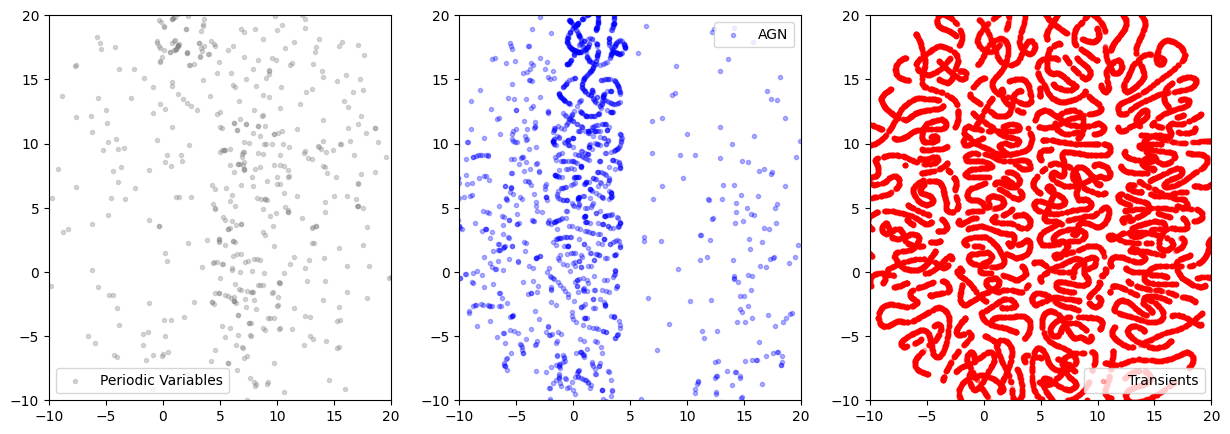

In [62]:
variables = []
agns = []
transients = []

for c in np.unique(filtered_classes):

    idx = np.where(filtered_classes == c)[0]
    if c in ["Cepheid", "Delta Scuti", "EB", "RR Lyrae"]:
        variables.append(embedding[idx, :])
        #axes[0].scatter(embedding[idx, 0], embedding[idx, 1], label="Periodic Variables", marker='.', color="gray", alpha=0.3)
    elif c == "AGN":
        agns.append(embedding[idx, :])
        #axes[1].scatter(embedding[idx, 0], embedding[idx, 1], label="AGN", marker='.', color="blue", alpha=0.3)
    else:
        transients.append(embedding[idx, :])
        #axes[2].scatter(embedding[idx, 0], embedding[idx, 1], label="Transients", marker='.', color="red", alpha=0.3)


variables = np.concatenate(variables)
agns = np.concatenate(agns)
transients = np.concatenate(transients)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))


axes[0].scatter(variables[:, 0], variables[:, 1], label="Periodic Variables", marker='.', color="gray", alpha=0.3)
axes[1].scatter(agns[:, 0], agns[:, 1], label="AGN", marker='.', color="blue", alpha=0.3)
axes[2].scatter(transients[:, 0], transients[:, 1], label="Transients", marker='.', color="red", alpha=0.3)

axes[0].legend()
axes[1].legend()
axes[2].legend()

# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (-10, 20)
custom_ylim = (-10, 20)

# Setting the values for all axes.
plt.setp(axes, xlim=custom_xlim, ylim=custom_ylim)